In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
# additional imports needed
from nltk.probability import FreqDist
import spacy

In [2]:
# custom function for preprocessing texts
def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
):
    """Efficiently preprocess a collection of texts using nlp.pipe()

    Args:
        texts (collection of strings): collection of texts to process (e.g. df['text'])
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
        disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
        batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
        n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).

    Returns:
        list of tokens
    """
    # from tqdm.notebook import tqdm
    from tqdm import tqdm

    if nlp is None:
        nlp = spacy.load("en_core_web_sm")

    processed_texts = []

    for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue

            
            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())

        processed_texts.append(tokens)
    return processed_texts

In [3]:
# Loading in 2017 News dataset
df = pd.read_csv("Data/Fake_Real_News_Data.csv")
df.head()

,Unnamed: 0,title,text,label
0,0,A whirlwind day in D.C. showcases Trump’s unor...,Donald Trump endorsed an unabashedly noninterv...,REAL
1,1,"In Baltimore's call for federal police probe, ...",While some Justice Department investigations a...,REAL
2,2,Trump Proudly Declares: Most Of The People I’v...,Trump Proudly Declares: Most Of The People I’v...,FAKE
3,3,Inside the Trump-Bush melodrama: Decades of te...,Donald Trump spent a day in January 2014 hobno...,REAL
4,4,Shutdown clash to return in force by December,Notable names include Ray Washburne (Commerce)...,REAL


# Cleaning Data

In [4]:
# Unnamed is just a blank integer column. 
df = df.drop(columns="Unnamed: 0")
df.head(3)

,title,text,label
0,A whirlwind day in D.C. showcases Trump’s unor...,Donald Trump endorsed an unabashedly noninterv...,REAL
1,"In Baltimore's call for federal police probe, ...",While some Justice Department investigations a...,REAL
2,Trump Proudly Declares: Most Of The People I’v...,Trump Proudly Declares: Most Of The People I’v...,FAKE


In [5]:
# Expanding our col widths so we can read our headlines
pd.get_option('display.max_colwidth')

50

In [6]:
pd.set_option('display.max_colwidth', 300)
df.head()

,title,text,label
0,A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone,"Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North Atlantic Treaty Organization and expressing skepticism about a muscular U.S. military presence in Asia.\n\nThe foreign policy pos...",REAL
1,"In Baltimore's call for federal police probe, a new search for answers (+video)","While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves included as part of the solution.\n\nSearching for a ""framework ... [to] heal,"" Baltimore Mayor Stephanie Rawlings-Blake put in a 911 cal...",REAL
2,Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It,"Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It By Andrew Bradford on October 27, 2016 Subscribe \nArrogance is defined as “an insulting way of thinking or behaving that comes from believing that you are better, smarter, or more important than other people.” In other words, ...",FAKE
3,Inside the Trump-Bush melodrama: Decades of tension and discomfort,"Donald Trump spent a day in January 2014 hobnobbing with politicians at the Trump International Golf Club in West Palm Beach, Fla. The billionaire mogul touted legalizing gambling with state Rep. Steve Crisafulli, speaker of the Florida House, and two other wired Florida Republicans, plugging hi...",REAL
4,Shutdown clash to return in force by December,"Notable names include Ray Washburne (Commerce), a Dallas-based investor, is reported to be under consideration to lead the department.",REAL


In [7]:
# Checking info nulls and duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


In [8]:
df.duplicated().sum()

29

In [9]:
# Dropping 29 duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

# Data Preparation

In [10]:
# We can use spacy to make a tokens columns using appropriate components
nlp_light = spacy.load("en_core_web_sm", disable=['parser','ner'])
# Print active components
nlp_light.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [11]:
# using custom function to preprocess our text column into tokens
df['tokens'] = batch_preprocess_texts(df['text'], nlp = nlp_light)
df.head()

6306it [02:35, 40.53it/s] 


,title,text,label,tokens
0,A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone,"Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North Atlantic Treaty Organization and expressing skepticism about a muscular U.S. military presence in Asia.\n\nThe foreign policy pos...",REAL,"[donald, trump, endorsed, unabashedly, noninterventionist, approach, world, affairs, monday, day, long, tour, washington, casting, doubt, need, north, atlantic, treaty, organization, expressing, skepticism, muscular, u.s., military, presence, asia, foreign, policy, positions, outlined, meeting, ..."
1,"In Baltimore's call for federal police probe, a new search for answers (+video)","While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves included as part of the solution.\n\nSearching for a ""framework ... [to] heal,"" Baltimore Mayor Stephanie Rawlings-Blake put in a 911 cal...",REAL,"[justice, department, investigations, adversarial, new, model, collaborative, reform, surprising, police, cities, find, included, solution, searching, framework, heal, baltimore, mayor, stephanie, rawlings, blake, 911, department, justice, ask, civil, rights, investigation, baltimore, police, de..."
2,Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It,"Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It By Andrew Bradford on October 27, 2016 Subscribe \nArrogance is defined as “an insulting way of thinking or behaving that comes from believing that you are better, smarter, or more important than other people.” In other words, ...",FAKE,"[trump, proudly, declares, people, insulted, deserved, andrew, bradford, october, 27, 2016, subscribe, arrogance, defined, insulting, way, thinking, behaving, comes, believing, better, smarter, important, people, words, donald, trump, perfectly, exemplifies, arrogance, proved, fact, appearing, g..."
3,Inside the Trump-Bush melodrama: Decades of tension and discomfort,"Donald Trump spent a day in January 2014 hobnobbing with politicians at the Trump International Golf Club in West Palm Beach, Fla. The billionaire mogul touted legalizing gambling with state Rep. Steve Crisafulli, speaker of the Florida House, and two other wired Florida Republicans, plugging hi...",REAL,"[donald, trump, spent, day, january, 2014, hobnobbing, politicians, trump, international, golf, club, west, palm, beach, fla., billionaire, mogul, touted, legalizing, gambling, state, rep., steve, crisafulli, speaker, florida, house, wired, florida, republicans, plugging, properties, potential, ..."
4,Shutdown clash to return in force by December,"Notable names include Ray Washburne (Commerce), a Dallas-based investor, is reported to be under consideration to lead the department.",REAL,"[notable, names, include, ray, washburne, commerce, dallas, based, investor, reported, consideration, lead, department]"


In [12]:
# batch preprocess the text and store lemmas
df['lemmas'] = batch_preprocess_texts(df['text'], nlp = nlp_light, use_lemmas = True)
df.head()

6306it [02:32, 41.41it/s] 


,title,text,label,tokens,lemmas
0,A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone,"Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North Atlantic Treaty Organization and expressing skepticism about a muscular U.S. military presence in Asia.\n\nThe foreign policy pos...",REAL,"[donald, trump, endorsed, unabashedly, noninterventionist, approach, world, affairs, monday, day, long, tour, washington, casting, doubt, need, north, atlantic, treaty, organization, expressing, skepticism, muscular, u.s., military, presence, asia, foreign, policy, positions, outlined, meeting, ...","[donald, trump, endorse, unabashedly, noninterventionist, approach, world, affair, monday, day, long, tour, washington, cast, doubt, need, north, atlantic, treaty, organization, express, skepticism, muscular, u.s., military, presence, asia, foreign, policy, position, outline, meeting, editorial,..."
1,"In Baltimore's call for federal police probe, a new search for answers (+video)","While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves included as part of the solution.\n\nSearching for a ""framework ... [to] heal,"" Baltimore Mayor Stephanie Rawlings-Blake put in a 911 cal...",REAL,"[justice, department, investigations, adversarial, new, model, collaborative, reform, surprising, police, cities, find, included, solution, searching, framework, heal, baltimore, mayor, stephanie, rawlings, blake, 911, department, justice, ask, civil, rights, investigation, baltimore, police, de...","[justice, department, investigation, adversarial, new, model, collaborative, reform, surprising, police, city, find, include, solution, search, framework, heal, baltimore, mayor, stephanie, rawlings, blake, 911, department, justice, ask, civil, right, investigation, baltimore, police, department..."
2,Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It,"Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It By Andrew Bradford on October 27, 2016 Subscribe \nArrogance is defined as “an insulting way of thinking or behaving that comes from believing that you are better, smarter, or more important than other people.” In other words, ...",FAKE,"[trump, proudly, declares, people, insulted, deserved, andrew, bradford, october, 27, 2016, subscribe, arrogance, defined, insulting, way, thinking, behaving, comes, believing, better, smarter, important, people, words, donald, trump, perfectly, exemplifies, arrogance, proved, fact, appearing, g...","[trump, proudly, declare, people, insult, deserved, andrew, bradford, october, 27, 2016, subscribe, arrogance, define, insulting, way, thinking, behave, come, believe, well, smart, important, people, word, donald, trump, perfectly, exemplify, arrogance, prove, fact, appear, good, morning, americ..."
3,Inside the Trump-Bush melodrama: Decades of tension and discomfort,"Donald Trump spent a day in January 2014 hobnobbing with politicians at the Trump International Golf Club in West Palm Beach, Fla. The billionaire mogul touted legalizing gambling with state Rep. Steve Crisafulli, speaker of the Florida House, and two other wired Florida Republicans, plugging hi...",REAL,"[donald, trump, spent, day, january, 2014, hobnobbing, politicians, trump, international, golf, club, west, palm, beach, fla., billionaire, mogul, touted, legalizing, gambling, state, rep., steve, crisafulli, speaker, florida, house, wired, florida, republicans, plugging, properties, potential, ...","[donald, trump, spend, day, january, 2014, hobnob, politician, trump, international, golf, club, west, palm, beach, fla., billionaire, mogul, tout, legalize, gambling, state, rep., steve, crisafulli, speaker, florida, house, wire, florida, republicans, plug, property, potential, site, casino, ta..."
4,Shutdown clash to

In [13]:
# Join list of tokens into a string with spaces between each token
df['tokens-joined'] = df['tokens'].map(lambda x: " ".join(x))
# Join list of lemmas into a string with spaces between each lemma
df['lemmas-joined'] = df['lemmas'].map(lambda x: " ".join(x))
df.head(3)

,title,text,label,tokens,lemmas,tokens-joined,lemmas-joined
0,A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone,"Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North Atlantic Treaty Organization and expressing skepticism about a muscular U.S. military presence in Asia.\n\nThe foreign policy pos...",REAL,"[donald, trump, endorsed, unabashedly, noninterventionist, approach, world, affairs, monday, day, long, tour, washington, casting, doubt, need, north, atlantic, treaty, organization, expressing, skepticism, muscular, u.s., military, presence, asia, foreign, policy, positions, outlined, meeting, ...","[donald, trump, endorse, unabashedly, noninterventionist, approach, world, affair, monday, day, long, tour, washington, cast, doubt, need, north, atlantic, treaty, organization, express, skepticism, muscular, u.s., military, presence, asia, foreign, policy, position, outline, meeting, editorial,...",donald trump endorsed unabashedly noninterventionist approach world affairs monday day long tour washington casting doubt need north atlantic treaty organization expressing skepticism muscular u.s. military presence asia foreign policy positions outlined meeting editorial board washington post c...,donald trump endorse unabashedly noninterventionist approach world affair monday day long tour washington cast doubt need north atlantic treaty organization express skepticism muscular u.s. military presence asia foreign policy position outline meeting editorial board washington post come day tr...
1,"In Baltimore's call for federal police probe, a new search for answers (+video)","While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves included as part of the solution.\n\nSearching for a ""framework ... [to] heal,"" Baltimore Mayor Stephanie Rawlings-Blake put in a 911 cal...",REAL,"[justice, department, investigations, adversarial, new, model, collaborative, reform, surprising, police, cities, find, included, solution, searching, framework, heal, baltimore, mayor, stephanie, rawlings, blake, 911, department, justice, ask, civil, rights, investigation, baltimore, police, de...","[justice, department, investigation, adversarial, new, model, collaborative, reform, surprising, police, city, find, include, solution, search, framework, heal, baltimore, mayor, stephanie, rawlings, blake, 911, department, justice, ask, civil, right, investigation, baltimore, police, department...",justice department investigations adversarial new model collaborative reform surprising police cities find included solution searching framework heal baltimore mayor stephanie rawlings blake 911 department justice ask civil rights investigation baltimore police department beat cop tactics week l...,justice department investigation adversarial new model collaborative reform surprising police city find include solution search framework heal baltimore mayor stephanie rawlings blake 911 department justice ask civil right investigation baltimore police department beat cop tactic week local pros...
2,Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It,"Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It By Andrew Bradford on October 27, 2016 Subscribe \nArrogance is defined as “an insulting way of thinking or behaving that comes from believing that you are better, smarter, or more important than other people.” In other words, ...",FAKE,"[trump, proudly, declares, people, insulted, deserved, andrew, bradford, october, 27, 2016, subscribe, arrogance, defined, insulting, way, thinking, behaving, comes, believing, better, smarter, important, people, words, donald, trump, perfectly, exemplifies, arrogance, proved, fact, appearing, g...","[trump, proudly, declare, people, insult, deserved, andrew, bradford, oc

In [14]:
df['label'].dtype

dtype('O')

In [15]:
# Let's filter our df by real and fake headlines
filter_r = df['label'] == 'REAL'
filter_f = df['label'] == 'FAKE'
# Checking our data balance
filter_r.sum(), filter_f.sum()

(3154, 3152)

In [16]:
# Make a single giant string with entire group of 5 star lemmas
real_lemmas = " ".join(df.loc[filter_r, 'lemmas-joined'])
# Make a single giant string with entire group of 1 star lemmas
fake_lemmas= " ".join(df.loc[filter_f, 'lemmas-joined'])

In [17]:
# Before using lemmas we can define some custom stopwords to clean our word cloud results
custom_stopwords = ['said', 'time', 'year', 'day', 'going', 'say', 'says', 'think']

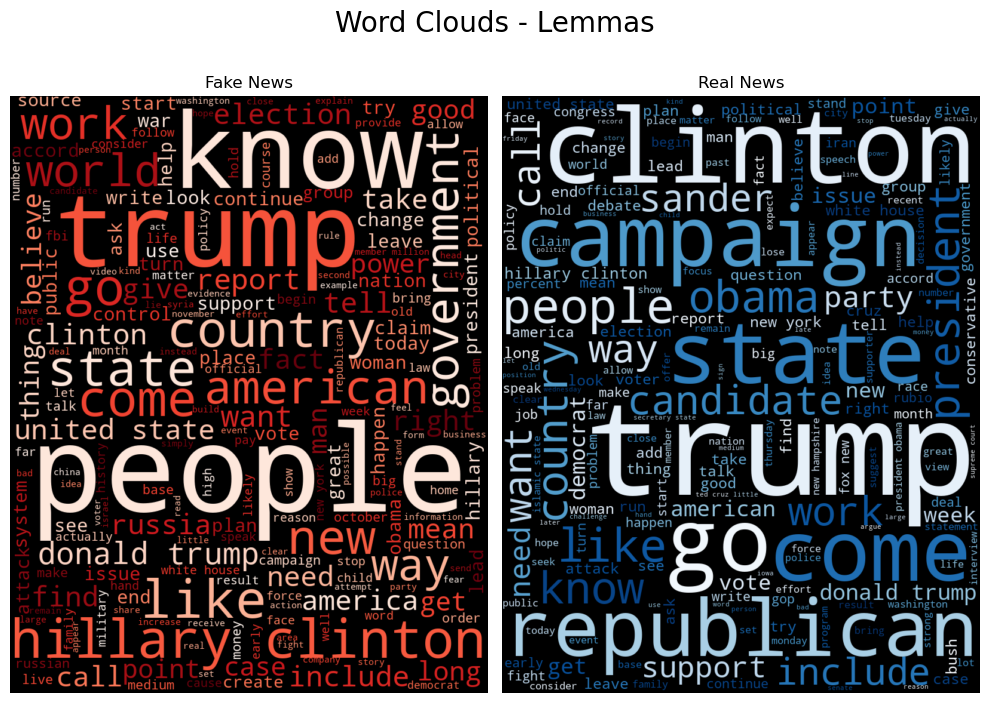

In [18]:
# Make word clouds of lemmas with custom stopwords
# Create an instance of a WordCloud and use the generate method
low_cloud = WordCloud(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 2, colormap="Reds",
                      stopwords = custom_stopwords
                     ).generate(fake_lemmas)
high_cloud = WordCloud(random_state = 42,
                       width = 800,
                       height= 1000,
                       min_word_length = 2,
                       colormap="Blues",
                       stopwords = custom_stopwords
                      ).generate(real_lemmas)
# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(low_cloud, interpolation='bilinear')
axes[0].set_title("Fake News")
axes[1].imshow(high_cloud, interpolation='bilinear')
axes[1].set_title("Real News")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Lemmas', fontsize=20, y=1.05);

In [19]:
# Making new column to find the average word count for real and fake news articles
df_r = df.loc[filter_r]
df_r['wc'] = df_r['tokens'].apply(lambda x: len(x))
df_r.head()

C:\Users\Rovidicus\AppData\Local\Temp\ipykernel_3608\1066392587.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_r['wc'] = df_r['tokens'].apply(lambda x: len(x))


,title,text,label,tokens,lemmas,tokens-joined,lemmas-joined,wc
0,A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone,"Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North Atlantic Treaty Organization and expressing skepticism about a muscular U.S. military presence in Asia.\n\nThe foreign policy pos...",REAL,"[donald, trump, endorsed, unabashedly, noninterventionist, approach, world, affairs, monday, day, long, tour, washington, casting, doubt, need, north, atlantic, treaty, organization, expressing, skepticism, muscular, u.s., military, presence, asia, foreign, policy, positions, outlined, meeting, ...","[donald, trump, endorse, unabashedly, noninterventionist, approach, world, affair, monday, day, long, tour, washington, cast, doubt, need, north, atlantic, treaty, organization, express, skepticism, muscular, u.s., military, presence, asia, foreign, policy, position, outline, meeting, editorial,...",donald trump endorsed unabashedly noninterventionist approach world affairs monday day long tour washington casting doubt need north atlantic treaty organization expressing skepticism muscular u.s. military presence asia foreign policy positions outlined meeting editorial board washington post c...,donald trump endorse unabashedly noninterventionist approach world affair monday day long tour washington cast doubt need north atlantic treaty organization express skepticism muscular u.s. military presence asia foreign policy position outline meeting editorial board washington post come day tr...,771
1,"In Baltimore's call for federal police probe, a new search for answers (+video)","While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves included as part of the solution.\n\nSearching for a ""framework ... [to] heal,"" Baltimore Mayor Stephanie Rawlings-Blake put in a 911 cal...",REAL,"[justice, department, investigations, adversarial, new, model, collaborative, reform, surprising, police, cities, find, included, solution, searching, framework, heal, baltimore, mayor, stephanie, rawlings, blake, 911, department, justice, ask, civil, rights, investigation, baltimore, police, de...","[justice, department, investigation, adversarial, new, model, collaborative, reform, surprising, police, city, find, include, solution, search, framework, heal, baltimore, mayor, stephanie, rawlings, blake, 911, department, justice, ask, civil, right, investigation, baltimore, police, department...",justice department investigations adversarial new model collaborative reform surprising police cities find included solution searching framework heal baltimore mayor stephanie rawlings blake 911 department justice ask civil rights investigation baltimore police department beat cop tactics week l...,justice department investigation adversarial new model collaborative reform surprising police city find include solution search framework heal baltimore mayor stephanie rawlings blake 911 department justice ask civil right investigation baltimore police department beat cop tactic week local pros...,600
3,Inside the Trump-Bush melodrama: Decades of tension and discomfort,"Donald Trump spent a day in January 2014 hobnobbing with politicians at the Trump International Golf Club in West Palm Beach, Fla. The billionaire mogul touted legalizing gambling with state Rep. Steve Crisafulli, speaker of the Florida House, and two other wired Florida Republicans, plugging hi...",REAL,"[donald, trump, spent, day, january, 2014, hobnobbing, politicians, trump, international, golf, club, west, palm, beach, fla., billionaire, mogul, touted, legalizing, gambling, state, rep., steve, crisafulli, speaker, florida, house, wired, florida, republicans, plugging, properties, potential, ...","[donald, trump, spend, day, january, 2014, hobnob, politician, 

In [20]:
# Getting average for real news articles
df_r['wc'].mean().round(0)

453.0

In [21]:
# Making new column to find the average word count for real and fake news articles
df_f = df.loc[filter_f]
df_f['wc'] = df_f['tokens'].apply(lambda x: len(x))
df_f.head(3)

C:\Users\Rovidicus\AppData\Local\Temp\ipykernel_3608\239707104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['wc'] = df_f['tokens'].apply(lambda x: len(x))


,title,text,label,tokens,lemmas,tokens-joined,lemmas-joined,wc
2,Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It,"Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It By Andrew Bradford on October 27, 2016 Subscribe \nArrogance is defined as “an insulting way of thinking or behaving that comes from believing that you are better, smarter, or more important than other people.” In other words, ...",FAKE,"[trump, proudly, declares, people, insulted, deserved, andrew, bradford, october, 27, 2016, subscribe, arrogance, defined, insulting, way, thinking, behaving, comes, believing, better, smarter, important, people, words, donald, trump, perfectly, exemplifies, arrogance, proved, fact, appearing, g...","[trump, proudly, declare, people, insult, deserved, andrew, bradford, october, 27, 2016, subscribe, arrogance, define, insulting, way, thinking, behave, come, believe, well, smart, important, people, word, donald, trump, perfectly, exemplify, arrogance, prove, fact, appear, good, morning, americ...",trump proudly declares people insulted deserved andrew bradford october 27 2016 subscribe arrogance defined insulting way thinking behaving comes believing better smarter important people words donald trump perfectly exemplifies arrogance proved fact appearing good morning america thursday morni...,trump proudly declare people insult deserved andrew bradford october 27 2016 subscribe arrogance define insulting way thinking behave come believe well smart important people word donald trump perfectly exemplify arrogance prove fact appear good morning america thursday morning gop nominee readi...,191
5,Can the great nuclear war be prevented ?,"«Current Concerns», n°23, October 22th, 2016\nCan the great nuclear war be prevented ? Can the great war be prevented … Russia and China are preparing for war – right in front of America’s doorstep, by Niki Vogt / Alert Memorandum for Obama warned to defuse tensions with Russia, by Veteran Intel...",FAKE,"[current, concerns, n, °, 23, october, 22th, 2016, great, nuclear, war, prevented, great, war, prevented, russia, china, preparing, war, right, america, doorstep, niki, vogt, alert, memorandum, obama, warned, defuse, tensions, russia, veteran, intelligence, professionals, sanity, vips, mayors, w...","[current, concerns, n, °, 23, october, 22th, 2016, great, nuclear, war, prevent, great, war, prevent, russia, china, prepare, war, right, america, doorstep, niki, vogt, alert, memorandum, obama, warn, defuse, tension, russia, veteran, intelligence, professionals, sanity, vips, mayors, warn, incr...",current concerns n ° 23 october 22th 2016 great nuclear war prevented great war prevented russia china preparing war right america doorstep niki vogt alert memorandum obama warned defuse tensions russia veteran intelligence professionals sanity vips mayors warn increasing danger war beaten war i...,current concerns n ° 23 october 22th 2016 great nuclear war prevent great war prevent russia china prepare war right america doorstep niki vogt alert memorandum obama warn defuse tension russia veteran intelligence professionals sanity vips mayors warn increase danger war beat war interview will...,115
6,"US charges 61 with India-based scam involving 15,000 victims","US charges 61 with India-based scam involving 15,000 victims US charges 61 with India-based scam involving 15,000 victims By 0 166 \nThe US Justice Department has charged 61 people and entities with involvement in a major India-based scam that targeted thousands of Americans. \nThe scheme involv...",FAKE,"[charges, 61, india, based, scam, involving, 15,000, victims, charges, 61, india, based, scam, involving, 15,000, victims, 0, 166, justice, department, charged, 61, people, entities, involvement, major, india, based, scam, targeted, thousands, americans, scheme, involved, indian, centers, worker...","[charge, 61, india, base, scam, involve, 15,000, victim, charge, 61, india, base, scam, involve, 15,000, victim, 0, 16

In [22]:
# Average word count of fake news articles
df_f['wc'].mean().round(0)

350.0

### We can clearly see a typical difference of ~100 fewer words for the fake articles

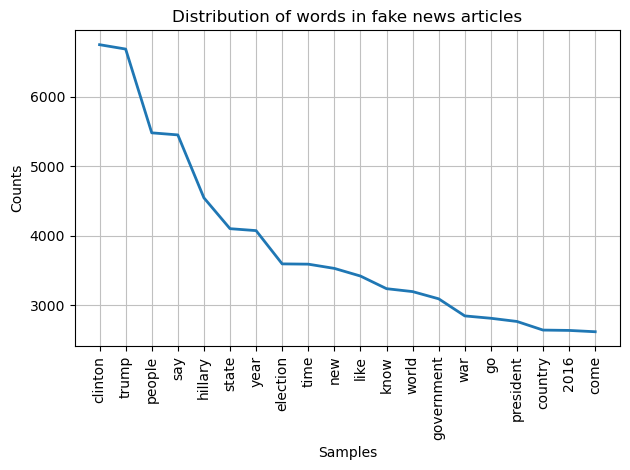

In [23]:
# Split the lemmas into individual token words
fake_lemmas_split = fake_lemmas.split()
# Pass the tokenized lemmas to the class constructor and plot the distribution 
fake_dist = FreqDist(fake_lemmas_split)
ax = fake_dist.plot(20, show = False, title='Distribution of words in fake news articles')
plt.tight_layout()
plt.savefig('fake_news_freq_dist.png');

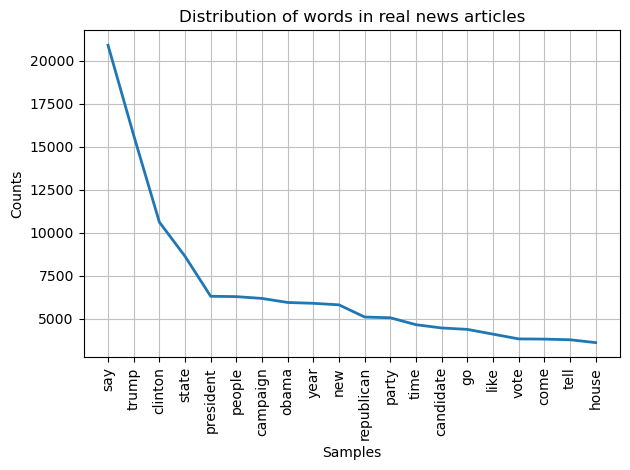

In [24]:
# Split the lemmas into individual token words
real_lemmas_split = real_lemmas.split()
# Pass the tokenized lemmas to the class constructor and plot the distribution 
real_dist = FreqDist(real_lemmas_split)
ax = real_dist.plot(20, show=False, title='Distribution of words in real news articles')
plt.tight_layout()
plt.savefig('real_news_freq_dist.png');

# Gridsearch and Vectorize

## Imports and Functions

In [25]:
# Importing packages
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [26]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## Data Split

In [27]:
# Defining our data to be train test split.
# We want our joined lemmatized data processed above
X = df['lemmas-joined']
y = df['label']

In [28]:
# Checking class balance 
y.value_counts(normalize=True)

REAL    0.500159
FAKE    0.499841
Name: label, dtype: float64

In [29]:
# Data is very balanced. Now splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Prepare Parameter Grids

In [33]:
# instantiating a count vectorizer
vectorizer = CountVectorizer()
# Transform train and test data with count vectorizer
X_train_cv = vectorizer.fit_transform(X_train)
X_test_cv = vectorizer.transform(X_test)

In [32]:
# Checking word count
len(vectorizer.vocabulary_)

50996

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      2395
        REAL       1.00      1.00      1.00      2334

    accuracy                           1.00      4729
   macro avg       1.00      1.00      1.00      4729
weighted avg       1.00      1.00      1.00      4729



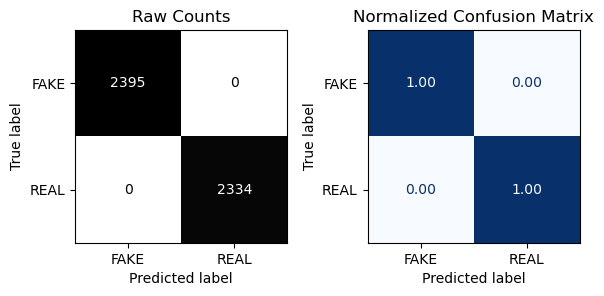


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.90      0.88      0.89       757
        REAL       0.89      0.91      0.90       820

    accuracy                           0.89      1577
   macro avg       0.89      0.89      0.89      1577
weighted avg       0.89      0.89      0.89      1577



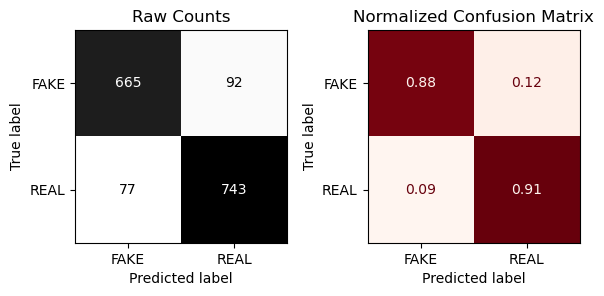

In [34]:
# Instantitate a Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_cv, y_train)
# Obtain evaluation metrics
evaluate_classification(clf, X_train_cv, y_train, X_test_cv, y_test)

In [35]:
# Create a pipeline with a vectorizer and classification model, with English stop words.
clf_pipe = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                     ('clf',RandomForestClassifier(random_state=42))])
clf_pipe

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      2395
        REAL       1.00      1.00      1.00      2334

    accuracy                           1.00      4729
   macro avg       1.00      1.00      1.00      4729
weighted avg       1.00      1.00      1.00      4729



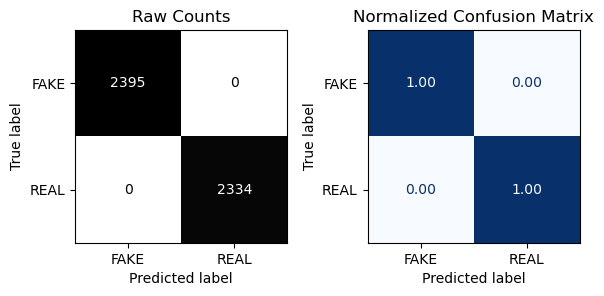


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.90      0.89      0.89       757
        REAL       0.90      0.91      0.90       820

    accuracy                           0.90      1577
   macro avg       0.90      0.90      0.90      1577
weighted avg       0.90      0.90      0.90      1577



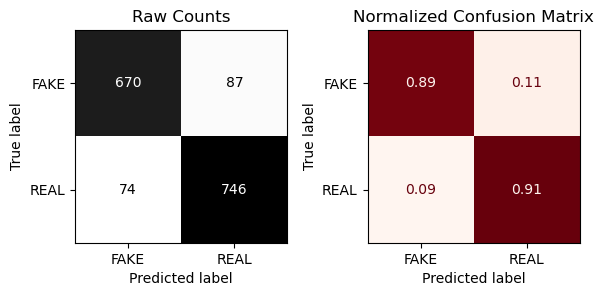

In [36]:
# Fit the model pipeline
clf_pipe.fit(X_train, y_train)
# Evaluate
evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test)

## Advanced Gridsearch CV

In [40]:
from sklearn.model_selection import GridSearchCV

In [38]:
# Set up Pipeline to allow GridSearching different vectorizers
vect_pipe = Pipeline([('vectorizer', CountVectorizer()), 
                     ('clf',MultinomialNB())])

In [50]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__ngram_range": [(1, 1), (1, 2),(2,2)],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
params_combined = [param_grid_count, param_grid_tfidf]

In [51]:
%%time
# Create grid search
grid_search = GridSearchCV(vect_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 810 candidates, totalling 2430 fits
CPU times: total: 1min 33s
Wall time: 57min 16s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'vectorizer': [CountVectorizer()],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
                          'vectorizer__stop_words': [None, 'engli...
                         {'vectorizer': [TfidfVectorizer(max_df=0.7, min_df=3,
                                                         ngram_range=(2, 2),
                                                         stop_words='english')],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
                          'vectorizer__norm': ['l1', 'l2'],
                          'vectorizer__stop_words': [None, 'english'],
                          'vectorizer__use_idf': [True, False]}],
             verbose=1)

In [52]:
grid_search.best_params_

{'vectorizer': TfidfVectorizer(max_df=0.7, min_df=3, ngram_range=(2, 2), stop_words='english'),
 'vectorizer__max_df': 0.7,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 3,
 'vectorizer__ngram_range': (2, 2),
 'vectorizer__norm': 'l2',
 'vectorizer__stop_words': 'english',
 'vectorizer__use_idf': True}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.99      0.98      0.98      2395
        REAL       0.98      0.99      0.98      2334

    accuracy                           0.98      4729
   macro avg       0.98      0.98      0.98      4729
weighted avg       0.98      0.98      0.98      4729



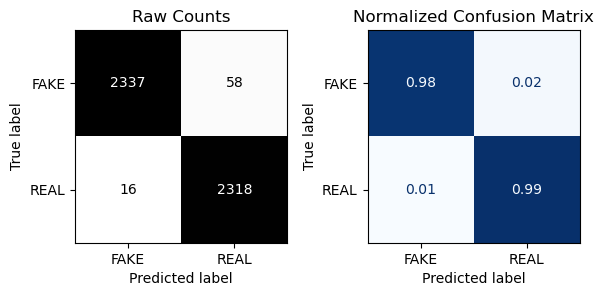


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.97      0.87      0.92       757
        REAL       0.89      0.97      0.93       820

    accuracy                           0.93      1577
   macro avg       0.93      0.92      0.93      1577
weighted avg       0.93      0.93      0.93      1577



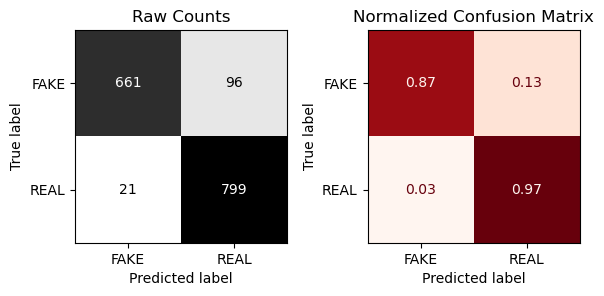

In [53]:
# Now define the best version of the model
best_model = grid_search.best_estimator_
# Predict and Evaluate with the custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)

### With MultinomialNB

In [54]:
# define grid with options for which vectorizer and which classifier
param_grid = {
    'vectorizer' : [CountVectorizer(), TfidfVectorizer()],
    'clf' : [RandomForestClassifier(random_state = 42), MultinomialNB(), LogisticRegression(random_state = 42)]
}

In [55]:
%%time
# Create grid search
grid_search = GridSearchCV(vect_pipe, param_grid, cv=3, scoring = 'accuracy', verbose=1, n_jobs=-1)
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
CPU times: total: 3.36 s
Wall time: 39.3 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf': [RandomForestClassifier(random_state=42),
                                 MultinomialNB(),
                                 LogisticRegression(random_state=42)],
                         'vectorizer': [CountVectorizer(), TfidfVectorizer()]},
             scoring='accuracy', verbose=1)

In [56]:
grid_search.best_params_

{'clf': LogisticRegression(random_state=42), 'vectorizer': TfidfVectorizer()}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.94      0.97      0.96      2395
        REAL       0.97      0.94      0.95      2334

    accuracy                           0.96      4729
   macro avg       0.96      0.96      0.96      4729
weighted avg       0.96      0.96      0.96      4729



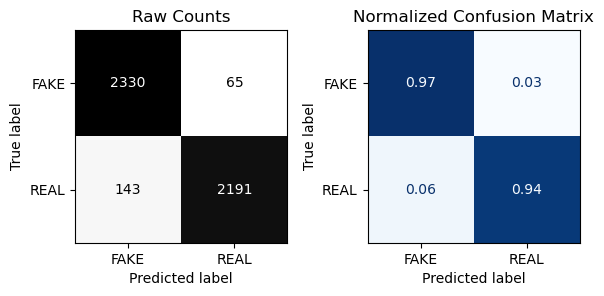


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.88      0.94      0.91       757
        REAL       0.94      0.88      0.91       820

    accuracy                           0.91      1577
   macro avg       0.91      0.91      0.91      1577
weighted avg       0.91      0.91      0.91      1577



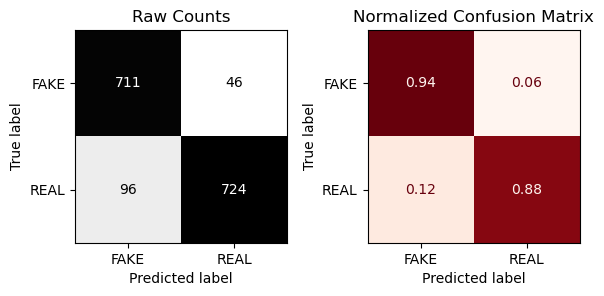

In [57]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)

In [82]:
# Define parameters to tune multiple models
shared_grid = {
    'vectorizer' : [CountVectorizer(max_df=0.7, min_df=3, ngram_range=(2, 2), stop_words='english'), 
                    TfidfVectorizer(max_df=0.7, min_df=3, ngram_range=(2, 2), stop_words='english')],
}
param_grid_RF = {
    'clf' : [RandomForestClassifier(random_state = 42)],
    'clf__max_depth' : [5, None],
    'clf__min_samples_leaf' : [1, 2],
    **shared_grid
}

param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],
    **shared_grid
}

param_grid_logreg = {
    'clf': [LogisticRegression(random_state = 42)],
    'clf__C' : [.1, 1, 10, 100],
    **shared_grid
}

# combine into list of params
params_combined = [param_grid_RF, param_grid_MNB, param_grid_logreg]

In [83]:
%%time
# Create grid search
grid_search = GridSearchCV(vect_pipe, params_combined, cv=3, scoring = 'accuracy', verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
CPU times: total: 10.2 s
Wall time: 2min 4s


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier(random_state=42)],
                          'clf__max_depth': [5, None],
                          'clf__min_samples_leaf': [1, 2],
                          'vectorizer': [CountVectorizer(max_df=0.7, min_df=3,
                                                         ngram_range=(2, 2),
                                                         stop_words='english'),
                                         TfidfVectorizer(max_df=0.7, min...
                                         TfidfVectorizer(max_df=0.7, min_df=3,
                                                         ngram_range=(2, 2),
                                                         stop_words='english')]},
                         {'clf': [LogisticRegression(C=100, random_state=42)],
                          'clf__C': [0.1, 1, 10, 100],
                          'vectorizer': [CountVectorizer(max_df=0.7, min_df=3,
                                                         ngram_range=(2, 2),
                                                         stop_words='english'),
                                         TfidfVectorizer(max_df=0.7, min_df=3,
                                                         ngram_range=(2, 2),
                                                         stop_words='english')]}],
             scoring='accuracy', verbose=1)

In [84]:
grid_search.best_params_

{'clf': LogisticRegression(C=100, random_state=42),
 'clf__C': 100,
 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=3, ngram_range=(2, 2), stop_words='english')}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      2395
        REAL       1.00      1.00      1.00      2334

    accuracy                           1.00      4729
   macro avg       1.00      1.00      1.00      4729
weighted avg       1.00      1.00      1.00      4729



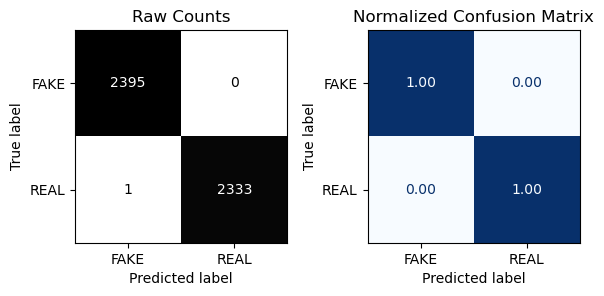


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.92      0.94      0.93       757
        REAL       0.95      0.92      0.93       820

    accuracy                           0.93      1577
   macro avg       0.93      0.93      0.93      1577
weighted avg       0.93      0.93      0.93      1577



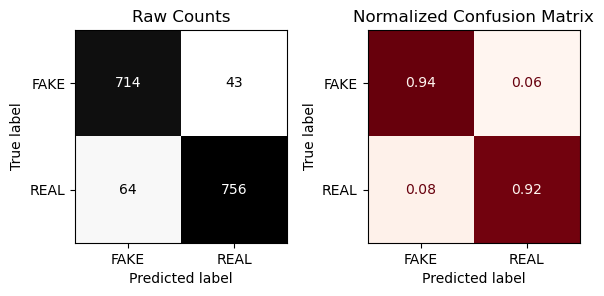

In [85]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)

## Itertools

In [75]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
vect_params_combined = [param_grid_count, param_grid_tfidf]

In [76]:
# Define parameters to tune multiple models
param_grid_RF = {
    'clf' : [RandomForestClassifier(random_state = 42)],
    'clf__max_depth' : [5, None],
    'clf__min_samples_leaf' : [1, 2],
}
param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],
}
param_grid_logreg = {
    'clf': [LogisticRegression(random_state = 42)],
    'clf__C' : [.1, 1, 10, 100],
}
# combine into list of params
model_params_combined = [param_grid_RF, param_grid_MNB, param_grid_logreg]

In [77]:
import itertools

paired_param_grids = list(itertools.product(vect_params_combined, model_params_combined))
paired_param_grids[0]

({'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']},
 {'clf': [RandomForestClassifier(random_state=42)],
  'clf__max_depth': [5, None],
  'clf__min_samples_leaf': [1, 2]})

In [78]:
final_params = []
for vector_params, model_params in  paired_param_grids:
    combined = {**vector_params, **model_params}
    final_params.append(combined)
final_params[0]

{'vectorizer': [CountVectorizer()],
 'vectorizer__max_df': [0.7, 0.8, 0.9],
 'vectorizer__min_df': [2, 3, 4],
 'vectorizer__max_features': [None, 1000, 2000],
 'vectorizer__stop_words': [None, 'english'],
 'clf': [RandomForestClassifier(random_state=42)],
 'clf__max_depth': [5, None],
 'clf__min_samples_leaf': [1, 2]}

In [79]:
%%time
# Create grid search
grid_search = GridSearchCV(vect_pipe, final_params, cv=3, scoring = 'accuracy', verbose=1, n_jobs=-1)    
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2700 candidates, totalling 8100 fits
CPU times: total: 4min 54s
Wall time: 2h 3min 51s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier(random_state=42)],
                          'clf__max_depth': [5, None],
                          'clf__min_samples_leaf': [1, 2],
                          'vectorizer': [CountVectorizer()],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectori...
                         {'clf': [LogisticRegression(C=10, random_state=42)],
                          'clf__C': [0.1, 1, 10, 100],
                          'vectorizer': [TfidfVectorizer(max_df=0.7, min_df=2)],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__norm': ['l1', 'l2'],
                          'vectorizer__stop_words': [None, 'english'],
                          'vectorizer__use_idf': [True, False]}],
             scoring='accuracy', verbose=1)

In [80]:
grid_search.best_params_

{'clf': LogisticRegression(C=10, random_state=42),
 'clf__C': 10,
 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=2),
 'vectorizer__max_df': 0.7,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 2,
 'vectorizer__norm': 'l2',
 'vectorizer__stop_words': None,
 'vectorizer__use_idf': True}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      2395
        REAL       1.00      1.00      1.00      2334

    accuracy                           1.00      4729
   macro avg       1.00      1.00      1.00      4729
weighted avg       1.00      1.00      1.00      4729



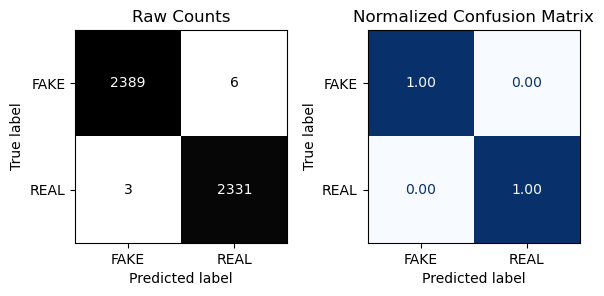


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.91      0.94      0.92       757
        REAL       0.94      0.91      0.93       820

    accuracy                           0.93      1577
   macro avg       0.92      0.93      0.93      1577
weighted avg       0.93      0.93      0.93      1577



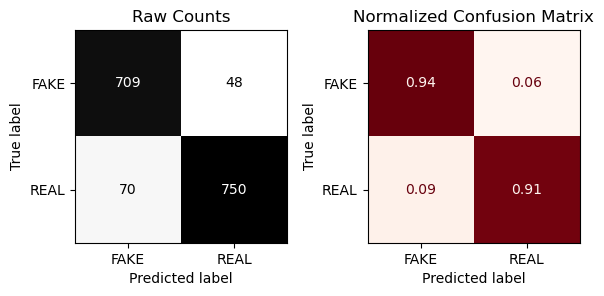

In [81]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)

### There's a blend of random forest models we could go with for determining real and fake news articles. Which to choose could depend on what we want to prioritize.
1. Our basic parameter model has an 89% score, very easy to run but not optimally tuned.
2. Adding 'English' stop words to our model increases accuracy by 1 percent. Simple but we can do better.
3. With our first Gridsearch model, we tuned our count and tfidf vectorizors. Predicting real articles jumped to 97% and overall accuracy reached 93%. However it took nearly an hour to run.
4. Running a simple Gridsearch that just chose vectorizor and model type, we could predict more fake articles at 94% with accuracy at 91%. The training data wasn't as overfit as other models.
5. Random Forest, Multinomial, and Logistic Regression model parameters are tuned and combined in GS. With this, we took the best parameters from model 3 and applied to our vectorizors. The result is a model as accurate as our best so far, well balanced with a load time under 2 minutes.
6. Itertools was used to join multiple models and vectorizors with params to see if final parameters could be tuned for a sharper model. The Gridsearch had 8100 fits that took over 2 hours to run. Metrics were comparable to model 5 for perhaps 60 times the computing power needed.

### Model 5 has the right balance of accuracy, run time and balance. It is a good candidate going forward to predict fake and real news.